# Montecarlo Simulations

This notebook will conduct the procedure for the **montecarlo** simulations, that simulate different random alternatives.

We will vary:
- amount of stocks bought day X (max 100);
- number of different stock tickers for the day;
- distribution of the day bought stocks for the different tickers.

We will assume that we can only buy stocks, and not sell, to begin with.

To decide which stocks can be bought at a certain day, we will use the LSTM predictions, and ...

## What stocks to buy on a certain day?

The result of the model prediction will be organized on a dataframe with the following format

| Date       | AAPL | MSFT | META | GOOG | ... |
|------------|------|------|------|------|-----|
| Jan 1st    |      |      |      |      |     |
| Jan 2nd    |      |      |      |      |     |
| Jan 3rd    |      |      |      |      |     |
| ...        |      |      |      |      |     |

In the blank spaces, can be 3 different attributes:

- **buy** signal: the model predicted a rise in the upcoming days;
- **sell** signal: the model predicted a decrease in the following days;
- **hold** signal: the model predicted either no change, or a change too small to buy/sell, considering a threshold defined on the other notebook.

## Montecarlo Planification

The algorithm will have different steps, and each simulation is described in the pseudocode that follows:

```py
inventory = {}
total_value = 10000

for day in month:
    diff_ticker_amount = random integer (a, b)                 # Generate a random number of stocks to buy total
    buy_tickers = get_buy_tickers()                  # Get the tickers to buy
    buy_distrib = get_buy_distribution(buy_tickers)  # Get the distribution of stocks to buy
    fees = size(buy_distrib)                         # Calculate fees based on the number of different stocks bought
    update_inventory(buy_distrib)                    # Update the inventory with the distribution
```

## Auxiliar methods

First of all, the imports required.

In [91]:
import random
from tqdm import tqdm
import time
import os
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

### Distribution
To allocate a certain number of stocks to each of the ticker buy list, we create the method `distribute_stocks(total_no, ticker_list)` that returns a dictionary that link to each stock in the buy list the number to buy (on a certain day).

We established a minimum of 1 stocks minimum for each ticker on the buy list, but that can be changed if needed.

In [92]:
def distribute_stocks(no_stock, tickers, minimum_no = 1):
    # Start by allocating the minimum of 1 stocks to each ticker
    allocation = {ticker: minimum_no for ticker in tickers}
    remaining_stocks = no_stock - minimum_no * len(tickers)

    # Distribute the remaining stocks randomly
    while remaining_stocks > 0:
        ticker = random.choice(tickers)
        allocation[ticker] += 1
        remaining_stocks -= 1

    return allocation

We can test the method in the cell below.

In [93]:
tickers = ["AAPL", "MSFT", "GOOG"]
no_stock = 50
result = distribute_stocks(no_stock, tickers)
result

{'AAPL': 16, 'MSFT': 19, 'GOOG': 15}

### Get Buy Tickers

To get the list of tickers to buy, for a specific date, we need to, given the dataframe (formatted as mentioned), get all the columns whose signal in the date row is a buy.

For testing we will use a more normalized dummy csv.

In [94]:
dummy_df = pd.read_csv('dummy_signals.csv')
dummy_df.head()

,Date,AAPL,MSFT,GOOG,META,TSLA,AMZN,NFLX,NVDA,AMD,INTC,SPGI,CRM,ADBE,PYPL,SMCI
0,2024-01-02,Buy,Hold,Sell,Buy,Hold,Sell,Buy,Sell,Hold,Buy,Hold,Sell,Buy,Hold,Sell
1,2024-01-03,Sell,Buy,Hold,Sell,Buy,Hold,Buy,Sell,Buy,Hold,Sell,Buy,Hold,Sell,Buy
2,2024-01-04,Hold,Sell,Buy,Hold,Sell,Buy,Hold,Buy,Sell,Buy,Hold,Sell,Buy,Hold,Sell
3,2024-01-05,Buy,Hold,Sell,Buy,Sell,Hold,Sell,Buy,Hold,Sell,Buy,Hold,Sell,Buy,Hold
4,2024-01-08,Sell,Buy,Hold,Hold,Buy,Hold,Buy,Hold,Sell,Buy,Hold,Sell,Hold,Buy,Sell


In [95]:
def get_buy_tickers(date, df):
    # Filter the row corresponding to the given date
    row = df[df['Date'] == date]
    
    if row.empty: # debug statement
        raise ValueError(f"No data found for date: {date}")

    buy_tickers = [ticker for ticker in df.columns[1:] if row[ticker].values[0] == 'Buy']
    
    return buy_tickers

We can test the function once more, by choosing a random date. The method takes a dataframe as argument to ensure it can be used for different csv files, resultant of different models.

In [96]:
get_buy_tickers("2024-01-04", dummy_df)

['GOOG', 'AMZN', 'NVDA', 'INTC', 'ADBE']

### Choose a random subset to buy

From the list of stocks with buy signals, it's not optimal to buy all of them. Instead we choose a small number (3-10) of stocks to buy that day.

In [97]:
def choose_random_stocks(stocks, n):
    # If the list has 0/1 stocks, return the list itself
    if len(stocks) <= 1:
        return stocks

    # Guarantee that n doesn't exceed the number of stocks available
    n = min(n, len(stocks))
    
    # Randomly select n stocks
    return random.sample(stocks, n)


To test, we define a list of random tickers, and guarantee it chooses correctly.

In [98]:
possible_stocks = [
    "AAPL", "MSFT", "GOOG", "META", "TSLA",  
    "AMZN", "NFLX", "NVDA", "AMD", "INTC",  
    "BABA", "CRM", "ADBE", "PYPL", "SQ"
]
n = random.randint(3,10)

selected_stocks = choose_random_stocks(possible_stocks, n)
selected_stocks

['NVDA', 'SQ', 'GOOG', 'PYPL', 'NFLX', 'CRM', 'AAPL', 'INTC']

### Update variables

Now we just need to update the inventory, with the new stocks bought, as well as the money available, to which needs the removal of the cost of the stocks, and the fees.

We will also define another methods to get the close price of a stock, for a given ticker and date, and we will store the total value (**balance + owned stocks**) to a dataframe, to later visualize the divergence of the random choices inherent to the algorithm.

During the project, we will consider the close price of the day before the buy price for today, instead of the opening price.

#### Update inventory

We can update the inventory with no restrictions, with the following method, that **returns the updated inventory** after a purchase.

In [99]:
def update_inventory(inventory, purchase):
    # Update inventory for the purchased stock
    new_inventory = inventory.copy()
    
    for ticker, amount in purchase.items():
        if ticker in new_inventory:
            new_inventory[ticker] += amount
        else:
            new_inventory[ticker] = amount

    return new_inventory

example_inventory = {"AAPL": 10, "MSFT": 5, "GOOG": 2}
example_purchase = {"AAPL": 5, "MSFT": 5, "NFLX": 2}

updated_inventory = update_inventory(example_inventory, example_purchase)

updated_inventory

{'AAPL': 15, 'MSFT': 10, 'GOOG': 2, 'NFLX': 2}

#### Update balance

We need to keep track of the balance and the inventory value, so we have a sense of performance during the algorithm. To get the closing price for a ticker and date we use the method below.

In [100]:
clean_dir = "./clean_csvs/"

def get_close_price(ticker, date):
    # Build path to file
    path = clean_dir + ticker + ".csv"
    df = pd.read_csv(path)
    
    price_row = df[(df['Date'] == date)]
    
    return round(float(price_row['Close'].values[0]), 2) # rounded to 2f

get_close_price("AAPL", "2024-01-04")

181.91

Using the method above, we can calculate the value of the inventory for a given date. 

The next method calculates the value of a dictionary on the format {Ticker: Qty}, that being a purchase or the inventory itself.

In [101]:
def calculate_inventory_value(inventory, date):
    total_value = 0.0
    
    for ticker, qty in inventory.items():
        # Get the close price for the ticker on the specified date
        close_price = get_close_price(ticker, date)
        
        # Calculate the value for the ticker and add to the total
        total_value += close_price * qty
    
    return round(total_value, 2)

example_inventory = {"AAPL": 10, "MSFT": 5, "GOOG": 2}
example_date = "2024-01-04"

calculate_inventory_value(example_inventory, example_date)

3934.88

Now we can implement a function that updates all variables and connects the concepts above. There are a lot of debug statements helpful for managing the code comprehension.

In [102]:
def update(old_inventory, purchase, old_balance, buy_date):
    # Inventory update
    new_inventory = update_inventory(old_inventory, purchase)

    # Inventory value update
    new_inventory_value = calculate_inventory_value(new_inventory, buy_date)

    # Calculate purchase price
    purchase_price = calculate_inventory_value(purchase, buy_date)
    #print(f"Initial purchase price: {purchase_price}")  

    fee = len(purchase.keys())  # 1$ per ticker
    #print(f"Fee for purchase: {fee}")  
    
    # Subtract the fee from the purchase price
    purchase_price += fee 
    
    #print(f"Purchase price after fee: {purchase_price}")  # Debugging stepsw2
    
    # Calculate new balance
    new_balance = old_balance - purchase_price

    return new_inventory, new_inventory_value, new_balance

# Example Usage
example_balance = 7000
example_inventory = {"AAPL": 10, "MSFT": 5, "GOOG": 2}
example_purchase = {"AAPL": 5, "MSFT": 5, "NFLX": 2}
example_date = "2024-01-04"

a, b, c = update(example_inventory, example_purchase, example_balance, example_date)
print(f"Updated Inventory: {a} (merge of the two)\nUpdated Inventory Value: {b}\nUpdated Balance: {c}")


Updated Inventory: {'AAPL': 15, 'MSFT': 10, 'GOOG': 2, 'NFLX': 2} (merge of the two)
Updated Inventory Value: 7633.47
Updated Balance: 3298.41


## Implementation

Following the methodology above described and the pseudocode, we can make a simulation for one day. We defined the minimum amount of stock to be bought in one day as 50, but can be changed if needed.

The procedure is the following:
- Get the list of tickers with a buy signal for the day,
- Get a subset of those, of size stock_no(nax), TBA,
- Buy some stocks total, chosen of that subset,
- Update variables.


In [103]:
inventory = {}
balance = 10000

date = "2024-01-04"
diff_ticker_amount = 3   

#print(diff_ticker_amount)
buy_tickers = get_buy_tickers(date, dummy_df) 
#print(buy_tickers)
list_buy_stocks = choose_random_stocks(buy_tickers, diff_ticker_amount)
#print(list_buy_stocks)
purchase = distribute_stocks(random.randint(3,5), list_buy_stocks)  # Get the distribution of stocks to buy
a, b, c = update(inventory, purchase, balance, date)
print(f"Updated Inventory: {a}\nUpdated Inventory Value: {b}\nUpdated Balance: {round(c)}")


Updated Inventory: {'ADBE': 2, 'AMZN': 2, 'GOOG': 1}
Updated Inventory Value: 1561.28
Updated Balance: 8436


### Iteration through the month

Now, we need to iterate through each row of the dataframe, and do the procedure.

In [104]:
# Initial values
inventory = {}
balance = 100000

# Iterate through the DataFrame
for index, row in dummy_df.iterrows():
    date = row["Date"]
    #print(date)

    # Generate stock number and determine tickers to buy
    diff_ticker_amount = 3  # Fixed stock number
    buy_tickers = get_buy_tickers(date, dummy_df)  # Get tickers with "Buy" signal
    list_buy_stocks = choose_random_stocks(buy_tickers, diff_ticker_amount)  # Random selection
    purchase = distribute_stocks(random.randint(3, 5), list_buy_stocks)  # Distribute stock purchases

    # Update inventory, value, and balance
    inventory, inventory_value, balance = update(inventory, purchase, balance, date)

    # Print results for this iteration
    print(f"Date: {date}")
    print(f"Purchase: {purchase}")
    print(f"Updated Inventory: {inventory}")
    print(f"Updated Inventory Value: {inventory_value}")
    print(f"Updated Balance: {round(balance)}\n")

    #sleep(1)

print(f"--------------------------------------------\nFinal Balance: {balance}")
print(f"Final Inventory Value: {inventory_value}")
print(f"Total: {balance+inventory_value}")



Date: 2024-01-02
Purchase: {'ADBE': 1, 'NFLX': 1, 'AAPL': 3}
Updated Inventory: {'ADBE': 1, 'NFLX': 1, 'AAPL': 3}
Updated Inventory Value: 1605.49
Updated Balance: 98392

Date: 2024-01-03
Purchase: {'NFLX': 1, 'CRM': 1, 'TSLA': 1}
Updated Inventory: {'ADBE': 1, 'NFLX': 2, 'AAPL': 3, 'CRM': 1, 'TSLA': 1}
Updated Inventory Value: 2555.35
Updated Balance: 97428

Date: 2024-01-04
Purchase: {'GOOG': 2, 'ADBE': 1, 'INTC': 1}
Updated Inventory: {'ADBE': 2, 'NFLX': 2, 'AAPL': 3, 'CRM': 1, 'TSLA': 1, 'GOOG': 2, 'INTC': 1}
Updated Inventory Value: 3441.29
Updated Balance: 96535

Date: 2024-01-05
Purchase: {'META': 1, 'SPGI': 2, 'NVDA': 1}
Updated Inventory: {'ADBE': 2, 'NFLX': 2, 'AAPL': 3, 'CRM': 1, 'TSLA': 1, 'GOOG': 2, 'INTC': 1, 'META': 1, 'SPGI': 2, 'NVDA': 1}
Updated Inventory Value: 4688.05
Updated Balance: 95275

Date: 2024-01-08
Purchase: {'INTC': 1, 'PYPL': 1, 'NFLX': 2}
Updated Inventory: {'ADBE': 2, 'NFLX': 4, 'AAPL': 3, 'CRM': 1, 'TSLA': 1, 'GOOG': 2, 'INTC': 2, 'META': 1, 'SPGI': 2

### Simulations

We can put all inside a function, and call that function ***n times***, corresponding to n simulations. We also considered to write a log file, and put exceptions for the dates not matching with the supposed. 

For that we define the method **simulation()** that simulates one full iteration through the dataframe, considering as attributes the initial money available. the balance and dataframe.

Based on an early attempt of montecarlo for the individual stock, in the `tesla_normalization_montecarlo.ipynb` file, we will use a [**pd.Series()**](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) to store the values, to then plot some graphs.

In [117]:
def simulation(df, iteration, inventory, balance=10000, min_distr = 3, max_distr = 5, diff_ticker_amount=3):  

    log_file_path = "log.txt"
    
    # Open the log file in append mode
    daily_series = pd.Series(dtype=float)
    
    with open(log_file_path, "a") as log_file:
        log_file.write(f"\n{'=' * 50}\n")  # Top border of the box
        log_file.write(f"|{'Iteration  ' + str(iteration):^50}|\n")  # Center the text with padding
        log_file.write(f"{'=' * 50}\n")  # Bottom border of the box

        for index, row in df.iterrows():
            date = row["Date"]
    
            try:
                # Generate stock number and determine tickers to buy
                buy_tickers = get_buy_tickers(date, df)
                if buy_tickers == []: # if no tickers with a buying signal, need exception
                    log_file.write(f"No stocks with a buying signal for the date {date}.\n")

                    # create variables the same way with null purchase
                    purchase = {}
                    inventory, inventory_value, balance = update(inventory, purchase, balance, date)

                    daily_series[index] = balance + inventory_value
                else:
                    list_buy_stocks = choose_random_stocks(buy_tickers, diff_ticker_amount)
                    
                    purchase = distribute_stocks(random.randint(min_distr, max_distr), list_buy_stocks)
        
                    # Update inventory, value, and balance
                    inventory, inventory_value, balance = update(inventory, purchase, balance, date)
        
                    # Write results for this iteration to log file
                    log_file.write(f"\nDate: {date}\n")
                    log_file.write(f"Available (with buy signal): {buy_tickers}\n")
                    log_file.write(f"Purchase: {purchase}\n")
                    log_file.write(f"Updated Inventory: {inventory}\n")
                    log_file.write(f"Updated Inventory Value: {inventory_value}\n")
                    log_file.write(f"Updated Balance: {round(balance)}\n\n")
    
                    # append to series
                    daily_series[index] = balance + inventory_value
                
    
            except ValueError as e:
                log_file.write(f"Error processing data for date {date}: {e}\n\n")

        log_file.write("--------------------------------------------------------------------------------------\n")

    return inventory, round(balance + inventory_value), daily_series

log_file_path = "log.txt"

# restart the log
with open(log_file_path, "w") as log_file:
    log_file.write("")
    
#simulation(dummy_df, 0, {}, 100000)


Now we can put it inside a "for i in range()" cycle, to simulate the number of simulations, and in the end keep the best one.

We will use `tqdm` module to add a loading bar, and use the `time` module to evaluate the final running time.

In [106]:
def montecarlo(df, no_iterations, balance=10000, min_distr=3, max_distr=5, diff_ticker_amount=3):
    results = pd.DataFrame()
    # Initialize baseline values
    best_inv = {}
    best_value = -1
    
    # Measure total runtime
    start = time.time()
    
    # Add tqdm for progress bar
    for iteration in tqdm(range(no_iterations), desc="Running Simulations"):
        # Perform the simulation
        i, v, daily_series = simulation(df, iteration+1, {}, balance, min_distr, max_distr, diff_ticker_amount)

        results[f"Simulation_{iteration}"] = daily_series.values
        
        if v > best_value:
            best_value = v
            best_inv = i
        
        
    end = time.time()
    total_time = end - start

    return total_time, best_inv, best_value, results

## Mutable Arguments for Montecarlo Simulations

Now, we will recap all the arguments mutable for the montecarlo algorithm:

- **no_iterations**: number of simulations of the algorithm.
- **balance**: initial balance for the user (default is 10000).
- **min_distr** and **max_distr**: the choice of how many stocks total is bought in a given day, we use *random.randint(min_distr, max_distr)* to decide (default is to buy 3 to 5 per day).
- **diff_ticker_amount**: max amount of different tickers in a day. Let's say 10 tickers have for a day X, a buy signal. Then, we choose diff_ticker_amount and then we distribute the quantity generated. Has to be **lower or equal than min_distr**. (default is 3).

In [118]:
balance = 20000

no_iterations = 20

min_distr = 1
max_distr = 2

diff_ticker_amount = 1

running_time, best_inventory, best_value, dummy_results = montecarlo(dummy_df, no_iterations, balance,
                                                                     min_distr, max_distr, diff_ticker_amount) 

print(f"Best (Final) Inventory: {best_inventory}")
print(f"Best Value: {best_value}")
print(f"Total Runtime: {running_time:.2f} seconds")

Running Simulations: 100%|██████████████████████| 20/20 [00:11<00:00,  1.78it/s]

Best (Final) Inventory: {'META': 1, 'AMD': 4, 'ADBE': 1, 'AAPL': 1, 'INTC': 1, 'SPGI': 2, 'AMZN': 1, 'NVDA': 2, 'NFLX': 2}
Best Value: 20129
Total Runtime: 11.21 seconds


Now we can plot the different simulations, and see how the price of the assets, inventory and balance, floating through the days of simulation.

**Disclaimer**: Dummy csv used, this plot is an example, and purely random.

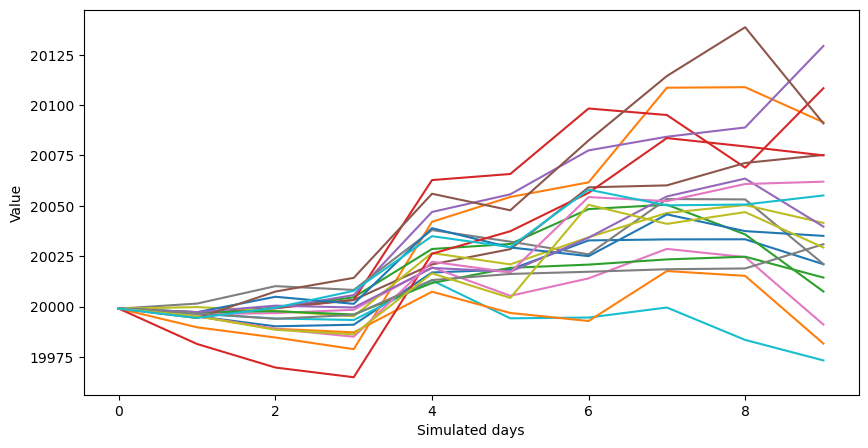

In [119]:
plt.figure(figsize=(10,5))
plt.plot(dummy_results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()

## LSTM

We can finally, implement all this work, but not the dummy file, but for the dataset resultant of the LSTM.

To summarise the process, we trained an LSTM for all the csvs mentioned and generated on the `report.ipynb`, and we did the following procedure:

- Using [pd.pct_change()*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html), we calculate the price flutuation for the stocks, for that given month, in percentage.
- We selected an adjustable threshold for a percentage, to be significant enough to generate a buying signal. It's key that such threshold isn't too small (and captures insignificant variations), not too high that (so it doesn't capture any significant flutuation at all).
- We generate the csv, following the same format as the one used above. 

### 1% Threshold

In [109]:
df_lstm1 = pd.read_csv('./lstm_signal_cleanup/trading_signals_1pct.csv')
df_lstm1.head()

,Date,C,CLX,BIIB,HAL,PANW,TSLA,F,CBOE,TRMB,...,RMD,PCAR,AEE,NUE,CHTR,HWM,TJX,TMO,HIG,GNRC
0,2024-01-02,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
1,2024-01-03,Buy,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2,2024-01-04,Buy,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell
3,2024-01-05,Buy,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell
4,2024-01-08,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell


In [122]:
lstm1_results = pd.DataFrame() # reset results

balance = 20000

no_iterations = 20

min_distr = 1
max_distr = 2

diff_ticker_amount = 1

running_time, best_inventory, best_value, lstm1_results = montecarlo(df_lstm1, no_iterations, balance,
                                                                     min_distr, max_distr, diff_ticker_amount) 

print(f"Best (Final) Inventory: {best_inventory}")
print(f"Best Value: {best_value}")
print(f"Total Runtime: {running_time:.2f} seconds")

Running Simulations: 100%|██████████████████████| 20/20 [00:35<00:00,  1.79s/it]

Best (Final) Inventory: {'WYNN': 2, 'C': 2, 'MRNA': 2, 'MRK': 2, 'UAL': 2, 'CTLT': 3, 'FICO': 1, 'SMCI': 2, 'PANW': 2, 'ISRG': 2, 'MU': 2, 'URI': 1, 'AMAT': 1, 'PCAR': 2, 'EOG': 2, 'HAS': 2}
Best Value: 20173
Total Runtime: 35.87 seconds


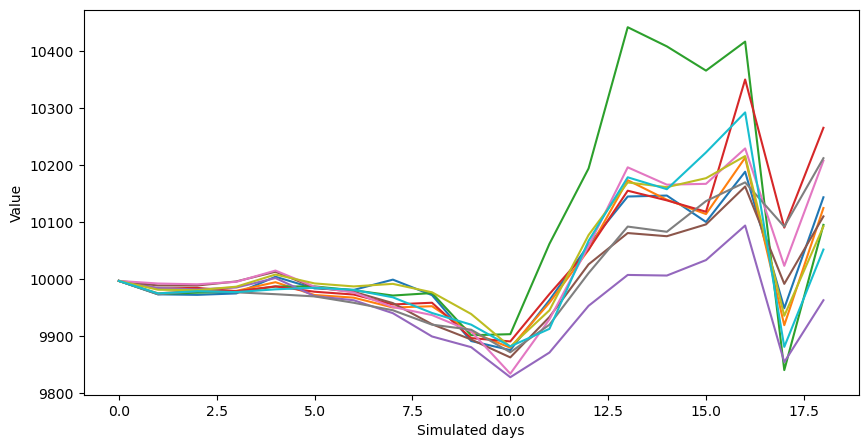

In [121]:
plt.figure(figsize=(10,5))
plt.plot(lstm_1pct_results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()

### 0.5% Threshold

In [112]:
df_lstm05 = pd.read_csv('./lstm_signal_cleanup/trading_signals_05pct.csv')
df_lstm05.head()

,Date,C,CLX,BIIB,HAL,PANW,TSLA,F,CBOE,TRMB,...,RMD,PCAR,AEE,NUE,CHTR,HWM,TJX,TMO,HIG,GNRC
0,2024-01-02,Buy,Hold,Buy,Hold,Sell,Hold,Sell,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
1,2024-01-03,Buy,Hold,Hold,Hold,Sell,Hold,Sell,Hold,Hold,...,Hold,Sell,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2,2024-01-04,Buy,Hold,Hold,Hold,Sell,Sell,Sell,Hold,Hold,...,Hold,Sell,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell
3,2024-01-05,Buy,Hold,Hold,Hold,Sell,Sell,Sell,Hold,Hold,...,Hold,Sell,Hold,Sell,Sell,Hold,Hold,Hold,Hold,Sell
4,2024-01-08,Buy,Hold,Hold,Sell,Hold,Sell,Hold,Hold,Hold,...,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell


In [113]:
results = pd.DataFrame()

running_time, best_inventory, best_value, lstm_05pct_results = montecarlo(df_lstm05, 5, balance=10000) 

print(f"Best (Final) Inventory: {best_inventory}")
print(f"Best Value: {best_value}")
print(f"Total Runtime: {running_time:.2f} seconds")

#lstm_05pct_results.to_csv('results_lstm_0.5', index=False)

Running Simulations: 100%|████████████████████████| 5/5 [00:23<00:00,  4.69s/it]

Best (Final) Inventory: {'MO': 2, 'MRK': 3, 'MOH': 2, 'CF': 1, 'MCK': 1, 'FE': 1, 'WYNN': 1, 'ED': 1, 'CNP': 3, 'ETR': 1, 'MRNA': 2, 'ALL': 1, 'ABBV': 1, 'FIS': 1, 'WRB': 1, 'BAX': 1, 'DAL': 1, 'SMCI': 2, 'DXCM': 1, 'JNPR': 1, 'DHI': 1, 'PGR': 2, 'URI': 3, 'STX': 1, 'FTNT': 1, 'SYK': 1, 'DECK': 1, 'NOW': 1, 'CRM': 1, 'ACN': 1, 'BK': 3, 'IT': 1, 'IBM': 2, 'CBOE': 1, 'AZO': 3, 'META': 1, 'WAT': 1, 'AMAT': 1, 'GOOG': 1, 'TYL': 1, 'CAT': 1, 'NWSA': 1, 'FTV': 1, 'PSX': 1, 'TXT': 1, 'TRV': 1, 'IPG': 2, 'DFS': 2}
Best Value: 10473
Total Runtime: 23.43 seconds


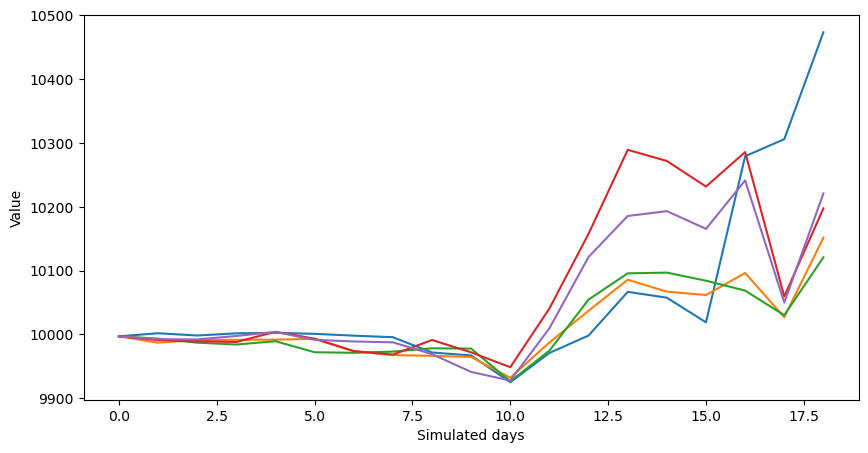

In [114]:
plt.figure(figsize=(10,5))
plt.plot(lstm_05pct_results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()